Riya Saini & Varun Bhakhri

# Assignment 6: Predictive Modeling of Housing Prices in Philadelphia

**Due date: Wednesday, 12/6 by the end of the day**


Lectures 12B and 13A will cover predictive modeling of housing prices in Philadelphia. We'll extend that analysis in this section by:

- Optimizing our hyperparameters during the modeling process using cross-validation and a grid search
- Testing the fairness of our model by calculating the intersection of the model error rate and poverty rate across neighborhoods

## Part 2: Modeling Philadelphia's Housing Prices and Algorithmic Fairness


### 2.1 Load data from the Office of Property Assessment

Use the requests package to query the CARTO API for **single-family** property assessment data in Philadelphia for properties that had their **last sale during 2022**.

Sources: 
- [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- [Metadata](http://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/)

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import hvplot.pandas

np.random.seed(42)

In [5]:
# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# Only pull 2022 sales for single family residential properties
where = "sale_date >= '2022-01-01' and sale_date <= '2022-12-31'"
where = where + " and category_code_description IN ('SINGLE FAMILY', 'Single Family')"

# Create the query
query = f"SELECT * FROM opa_properties_public WHERE {where}"

# Make the request
params = {"q": query, "format": "geojson"}
response = requests.get(carto_url, params=params)

In [6]:
# Make the GeoDataFrame
salesRaw = gpd.GeoDataFrame.from_features(response.json(), crs="EPSG:4326")

# Optional: put it a reproducible order for test/training splits later
salesRaw = salesRaw.sort_values("parcel_number")

In [7]:
# Selecting columns:
cols = [
    "sale_price",
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "exterior_condition",
    "zip_code",
]

# Trim to these columns and remove NaNs
sales = salesRaw[cols + ["geometry"]].dropna()

# Trim zip code to only the first five digits
sales["zip_code"] = sales["zip_code"].astype(str).str.slice(0, 5)

In [8]:
sales.head()

,sale_price,total_livable_area,total_area,garage_spaces,fireplaces,number_of_bathrooms,number_of_bedrooms,number_stories,exterior_condition,zip_code,geometry
1133,450000.0,1785.0,1625.0,1.0,0.0,2.0,3.0,3.0,4,19147,POINT (-75.14860 39.93145)
13106,670000.0,2244.0,1224.0,0.0,0.0,3.0,4.0,3.0,3,19147,POINT (-75.14817 39.93101)
7860,790000.0,2514.0,1400.0,1.0,0.0,0.0,3.0,2.0,3,19147,POINT (-75.14781 39.93010)
835,195000.0,1358.0,840.0,0.0,0.0,2.0,3.0,3.0,4,19147,POINT (-75.14887 39.93026)
12456,331000.0,868.0,546.0,0.0,0.0,2.0,2.0,2.0,4,19147,POINT (-75.14881 39.93012)


### 2.2 Load data for census tracts and neighborhoods

Load various Philadelphia-based regions that we will use in our analysis. 

- Census tracts can be downloaded from: [https://opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson](https://opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson)
- Neighborhoods can be downloaded from:
[https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson](https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson)


In [9]:
tracts = gpd.read_file("Data/Census_Tracts_2010.geojson")
neighborhoods = gpd.read_file("Data/philadelphia-neighborhoods.geojson")

In [10]:
tracts.head()

,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,geometry
0,1,42,101,009400,42101009400,94,Census Tract 94,G5020,S,366717,0,+39.9632709,-075.2322437,10429,"POLYGON ((-75.22927 39.96054, -75.22865 39.960..."
1,2,42,101,009500,42101009500,95,Census Tract 95,G5020,S,319070,0,+39.9658709,-075.2379140,10430,"POLYGON ((-75.23536 39.96852, -75.23545 39.969..."
2,3,42,101,009600,42101009600,96,Census Tract 96,G5020,S,405273,0,+39.9655396,-075.2435075,10431,"POLYGON ((-75.24343 39.96230, -75.24339 39.962..."
3,4,42,101,013800,42101013800,138,Census Tract 138,G5020,S,341256,0,+39.9764504,-075.1771771,10468,"POLYGON ((-75.17341 39.97779, -75.17386 39.977..."
4,5,42,101,013900,42101013900,139,Census Tract 139,G5020,S,562934,0,+39.9750563,-075.1711846,10469,"POLYGON ((-75.17313 39.97776, -75.17321 39.977..."


In [11]:
neighborhoods.head()

,NAME,LISTNAME,MAPNAME,Shape_Leng,Shape_Area,geometry
0,BRIDESBURG,Bridesburg,Bridesburg,27814.546521,4.458626e+07,"MULTIPOLYGON (((-75.06773 40.00540, -75.06765 ..."
1,BUSTLETON,Bustleton,Bustleton,48868.458365,1.140504e+08,"MULTIPOLYGON (((-75.01560 40.09487, -75.01768 ..."
2,CEDARBROOK,Cedarbrook,Cedarbrook,20021.415802,2.487174e+07,"MULTIPOLYGON (((-75.18848 40.07273, -75.18846 ..."
3,CHESTNUT_HILL,Chestnut Hill,Chestnut Hill,56394.297195,7.966498e+07,"MULTIPOLYGON (((-75.21221 40.08604, -75.21210 ..."
4,EAST_FALLS,East Falls,East Falls,27400.776417,4.057689e+07,"MULTIPOLYGON (((-75.18476 40.02829, -75.18426 ..."


### 2.3 Spatially join the sales data and neighborhoods/census tracts.

Perform a spatial join, such that each sale has an associated neighborhood and census tract.

**Note:** After performing the first spatial join, you will need to use the `drop()` function to remove the `index_right` column; otherwise an error will be raised on the second spatial join about duplicate columns.

In [12]:
sales_geo1 = gpd.sjoin(
    sales,
    tracts,         # Polygon data
    how="left",            # Type of join: 'left', 'inner', or 'right'
    predicate="intersects" # Use "intersects" to join based on spatial intersection
)

In [13]:
sales_geo1 = sales_geo1.drop(columns=['index_left', 'index_right'], errors='ignore')
neighborhoods = neighborhoods.drop(columns=['index_left', 'index_right'], errors='ignore')

In [14]:
sales_geo2 = gpd.sjoin(
    sales_geo1,
    neighborhoods,         # Polygon data
    how="left",            # Type of join: 'left', 'inner', or 'right'
    predicate="intersects" # Use "intersects" to join based on spatial intersection
)

In [15]:
sales_geo2.head()

,sale_price,total_livable_area,total_area,garage_spaces,fireplaces,number_of_bathrooms,number_of_bedrooms,number_stories,exterior_condition,zip_code,...,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,index_right,NAME,LISTNAME,MAPNAME,Shape_Leng,Shape_Area
1133,450000.0,1785.0,1625.0,1.0,0.0,2.0,3.0,3.0,4,19147,...,0,+39.9280114,-075.1495606,10368,154,PENNSPORT,Pennsport,Pennsport,11823.233108,6.492473e+06
13106,670000.0,2244.0,1224.0,0.0,0.0,3.0,4.0,3.0,3,19147,...,0,+39.9280114,-075.1495606,10368,154,PENNSPORT,Pennsport,Pennsport,11823.233108,6.492473e+06
7860,790000.0,2514.0,1400.0,1.0,0.0,0.0,3.0,2.0,3,19147,...,0,+39.9280114,-075.1495606,10368,154,PENNSPORT,Pennsport,Pennsport,11823.233108,6.492473e+06
835,195000.0,1358.0,840.0,0.0,0.0,2.0,3.0,3.0,4,19147,...,0,+39.9280114,-075.1495606,10368,154,PENNSPORT,Pennsport,Pennsport,11823.233108,6.492473e+06
12456,331000.0,868.0,546.0,0.0,0.0,2.0,2.0,2.0,4,19147,...,0,+39.9280114,-075.1495606,10368,154,PENNSPORT,Pennsport,Pennsport,11823.233108,6.492473e+06


In [16]:
# Check columns:

print(sales_geo1.columns)

print(sales_geo2.columns)


Index(['sale_price', 'total_livable_area', 'total_area', 'garage_spaces',
       'fireplaces', 'number_of_bathrooms', 'number_of_bedrooms',
       'number_stories', 'exterior_condition', 'zip_code', 'geometry',
       'OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'LOGRECNO'],
      dtype='object')
Index(['sale_price', 'total_livable_area', 'total_area', 'garage_spaces',
       'fireplaces', 'number_of_bathrooms', 'number_of_bedrooms',
       'number_stories', 'exterior_condition', 'zip_code', 'geometry',
       'OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'LOGRECNO', 'index_right', 'NAME',
       'LISTNAME', 'MAPNAME', 'Shape_Leng', 'Shape_Area'],
      dtype='object')


In [19]:
# The feature columns we want to use:

cols = [
    "sale_price",
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "exterior_condition",
    "GEOID10", 
    "NAME"
]

# Trim to these columns and remove NaNs
sales = sales_geo2[cols + ["geometry"]].dropna()


### 2.4 Train a Random Forest on the sales data

In this step, you should follow the steps outlined in lecture to preprocess and train your model. We'll extend our analysis to do a hyperparameter grid search to find the best model configuration. As you train your model, follow the following steps:

**Preprocessing Requirements**
- Trim the sales data to those sales with prices between $3,000 and $1 million
- Set up a pipeline that includes both numerical columns and categorical columns
- Include one-hot encoded variable for the *neighborhood* of the sale, **instead of ZIP code**. We don't want to include multiple location based categories, since they encode much of the same information.

**Training requirements**
- Use a 70/30% training/test split and predict the log of the sales price.
- Use GridSearchCV to perform a k-fold cross validation that optimize *at least 2* hyperparameters of the RandomForestRegressor
- After fitting your model and finding the optimal hyperparameters, you should evaluate the score (R-squared) on the test set (the original 30% sample withheld)

**Note**: You don't need to include additional features (such as spatial distance features) or perform any extra feature engineering beyond what is required above to receive full credit. Of course, you are always welcome to experiment!

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import numpy as np

#Preprocessing:

# Filter valid sales
valid = (sales_geo2['sale_price'] > 3000) & (sales_geo2['sale_price'] < 1000000)
sales_final = sales_geo2.loc[valid]

# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]

# Categorical columns
cat_cols = ["exterior_condition", "NAME"]

# Preprocessor
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Initialize RandomForestRegressor (no specific hyperparameters yet)
rf = RandomForestRegressor(random_state=42)

# Build pipeline
pipe = Pipeline(steps=[
    ('preprocessor', transformer),
    ('regressor', rf)
])

# Split data 70/30
train_set, test_set = train_test_split(sales_final, test_size=0.3, random_state=42)

# Separate features (X) and target (y)
X_train = train_set.drop(columns=["sale_price"])
X_test = test_set.drop(columns=["sale_price"])
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

# Define hyperparameter grid for RandomForest
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5]
}

In [31]:
# Perform GridSearchCV with k-fold cross-validation
grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=3,  # k-fold cross-validation
    scoring='r2',  # R-squared as the scoring metric
    n_jobs=-1,  # Use all processors
    verbose=2
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"R-squared on Test Set: {r2:.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'regressor__max_depth': 20, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
R-squared on Test Set: 0.5505


### 2.5 Calculate the percent error of your model predictions for each sale in the test set

Fit your best model and use it to make predictions on the test set.

**Note:** This should be the percent error in terms of **sale price**. You'll need to convert if your model predicted the log of sales price!

In [32]:
# Convert log predictions back to original sale prices
y_pred_log = grid_search.best_estimator_.predict(X_test)
y_pred = np.exp(y_pred_log)  # Convert from log scale to original scale

# Actual sale prices from the test set
y_actual = np.exp(y_test)  # Convert log-transformed test target back to original scale

# Calculate percent error for each sale
percent_error = 100 * np.abs((y_actual - y_pred) / y_actual)

# Add percent error to a DataFrame for easier inspection
test_results = test_set.copy()
test_results["Actual Sale Price"] = y_actual
test_results["Predicted Sale Price"] = y_pred
test_results["Percent Error (%)"] = percent_error

In [36]:
test_results.head(10)

,sale_price,total_livable_area,total_area,garage_spaces,fireplaces,number_of_bathrooms,number_of_bedrooms,number_stories,exterior_condition,zip_code,...,LOGRECNO,index_right,NAME,LISTNAME,MAPNAME,Shape_Leng,Shape_Area,Actual Sale Price,Predicted Sale Price,Percent Error (%)
8156,120000.0,1284.0,1072.0,0.0,0.0,1.0,3.0,1.0,4,19143,...,10413,118,COBBS_CREEK,Cobbs Creek,Cobbs Creek,25355.994460,3.755230e+07,120000.0,153636.386142,28.030322
13566,58500.0,1792.0,1120.0,0.0,0.0,1.0,4.0,2.0,4,19134,...,10509,76,UPPER_KENSINGTON,Upper Kensington,Upper Kensington,19841.099278,2.278303e+07,58500.0,83345.391195,42.470754
22550,80000.0,1120.0,937.0,0.0,0.0,2.0,3.0,2.0,4,19142,...,10397,115,PASCHALL,Paschall,Paschall,22650.029678,1.966201e+07,80000.0,189014.571783,136.268215
19208,150000.0,1046.0,1209.0,1.0,0.0,1.0,3.0,2.0,4,19136,...,10639,39,HOLMESBURG,Holmesburg,Holmesburg,40376.277535,8.406447e+07,150000.0,153004.834966,2.003223
19616,157100.0,900.0,1396.0,0.0,0.0,1.0,2.0,2.0,4,19128,...,10536,50,ROXBOROUGH,Roxborough,Roxborough,23054.709844,2.241660e+07,157100.0,168547.045501,7.286471
5193,100000.0,896.0,1293.0,0.0,0.0,1.0,3.0,2.0,4,19124,...,10517,73,JUNIATA_PARK,Juniata Park,Juniata Park,30347.187784,3.244185e+07,100000.0,118884.863137,18.884863
18465,284999.0,820.0,786.0,0.0,0.0,1.0,2.0,2.0,4,19125,...,10488,149,EAST_KENSINGTON,East Kensington,East Kensington,11570.514789,7.672347e+06,284999.0,172547.643360,39.456755
16338,200000.0,1360.0,3523.0,0.0,0.0,1.0,3.0,2.0,4,19154,...,10683,17,PARKWOOD_MANOR,Parkwood Manor,Parkwood Manor,36872.934875,4.700604e+07,200000.0,267007.092470,33.503546
20174,26000.0,1182.0,845.0,0.0,0.0,1.0,3.0,2.0,4,19140,...,10526,62,TIOGA,Tioga,Tioga,27189.667081,3.162796e+07,26000.0,114379.990600,339.923041
17738,17000.0,702.0,520.0,0.0,0.0,1.0,2.0,1.0,4,19140,...,10521,76,UPPER_KENSINGTON,Upper Kensington,Upper Kensington,19841.099278,2.278303e+07,17000.0,42469.103986,149.818259


### 2.6 Make a data frame with percent errors and census tract info for each sale in the test set

Create a data frame that has the property geometries, census tract data, and percent errors for all of the sales in the test set.

**Notes**

- When using the "train_test_split()" function, the index of the test data frame includes the labels from the original sales data frame
- You can use this index to slice out the test data from the original sales data frame, which should include the census tract info and geometries
- Add a new column to this data frame holding the percent error data
- Make sure to use the percent error and not the absolute percent error



In [45]:
test_data_with_geometry = sales.loc[test_set.index]

test_data_census = test_data_with_geometry.join(
    test_results["Percent Error (%)"], how="left"
)

test_data_census.head()

,sale_price,total_livable_area,total_area,garage_spaces,fireplaces,number_of_bathrooms,number_of_bedrooms,number_stories,exterior_condition,GEOID10,NAME,geometry,Percent Error (%)
8156,120000.0,1284.0,1072.0,0.0,0.0,1.0,3.0,1.0,4,42101008102,COBBS_CREEK,POINT (-75.23493 39.95220),28.030322
13566,58500.0,1792.0,1120.0,0.0,0.0,1.0,4.0,2.0,4,42101017702,UPPER_KENSINGTON,POINT (-75.12162 39.99780),42.470754
22550,80000.0,1120.0,937.0,0.0,0.0,2.0,3.0,2.0,4,42101006400,PASCHALL,POINT (-75.23767 39.92786),136.268215
19208,150000.0,1046.0,1209.0,1.0,0.0,1.0,3.0,2.0,4,42101032900,HOLMESBURG,POINT (-75.02733 40.03371),2.003223
19616,157100.0,900.0,1396.0,0.0,0.0,1.0,2.0,2.0,4,42101021000,ROXBOROUGH,POINT (-75.21195 40.02551),7.286471


### 2.8 Plot a map of the median percent error by census tract 

- You'll want to group your data frame of test sales by the `GEOID10` column and take the median of you percent error column
- Merge the census tract geometries back in and use geopandas to plot.

In [49]:
#Group by GEOID10 and calculate the median percent error

test_data_grouped = test_data_census.groupby("GEOID10")["Percent Error (%)"].median().reset_index()
test_data_grouped.rename(columns={"Percent Error (%)": "Median Percent Error"}, inplace=True)

test_data_tracts = tracts.merge(test_data_grouped, on="GEOID10", how="left")

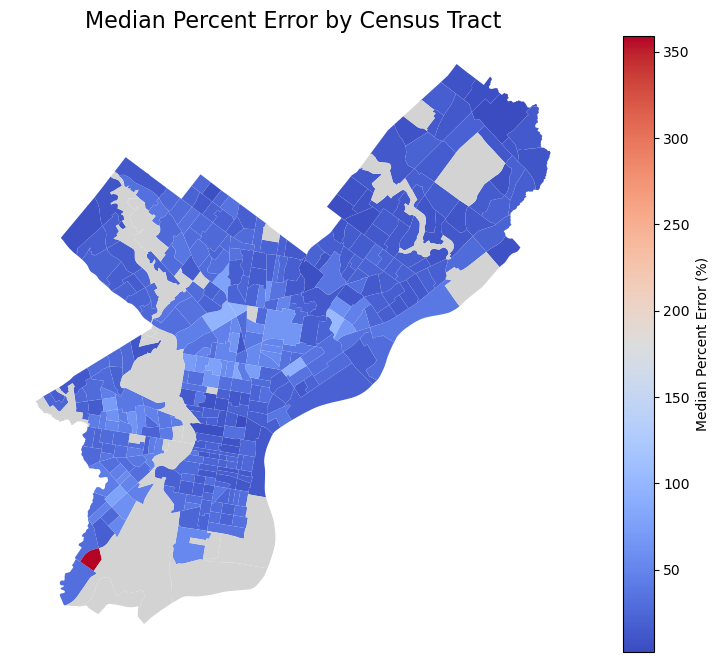

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
test_data_tracts.plot(
    column="Median Percent Error",  # Data to color by
    cmap="coolwarm",  # Color map
    legend=True,
    legend_kwds={"label": "Median Percent Error (%)"},
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)
ax.set_title("Median Percent Error by Census Tract", fontsize=16)
ax.axis("off")

plt.show()

One census tract has a high error and is skewing the choropleth

(-75.29653466356935, -74.93952065285654, 39.853948713668416, 40.15145798905888)

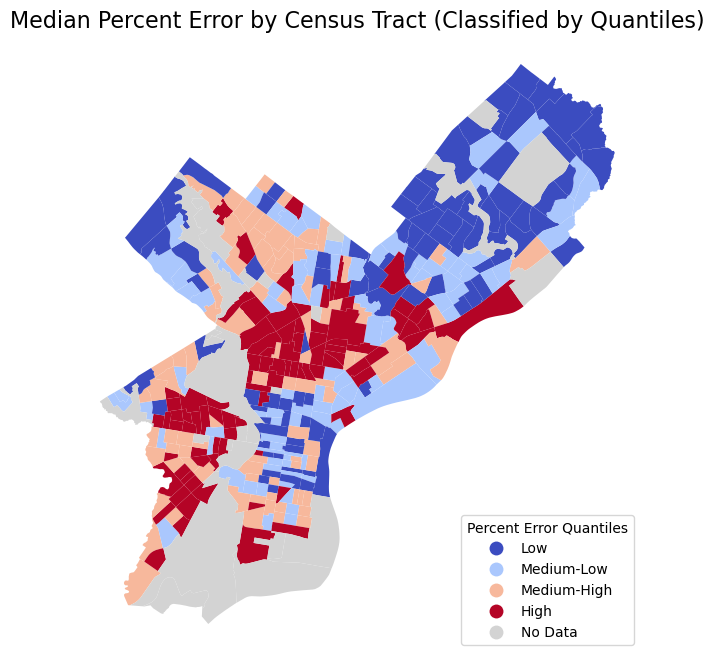

In [53]:
test_data_tracts["Error Quantile"] = pd.qcut(
    test_data_tracts["Median Percent Error"], 
    q=4,  # Divide into 4 quantiles (quartiles)
    labels=["Low", "Medium-Low", "Medium-High", "High"]
)

# Step 2: Plot using GeoPandas
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
test_data_tracts.plot(
    column="Error Quantile",  # Data to classify by
    cmap="coolwarm",  # Color map
    legend=True,
    legend_kwds={
        "title": "Percent Error Quantiles",
        "loc": "lower right"
    },
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)
ax.set_title("Median Percent Error by Census Tract (Classified by Quantiles)", fontsize=16)
ax.axis("off")

Classifying the errors by quantiles reveals a clearer picture. Tracts in Central Philadelphia have a higher error rate than others.

### 2.9 Compare the percent errors in Qualifying Census Tracts and other tracts 

[Qualifying Census Tracts](https://www.huduser.gov/portal/datasets/qct.html) are a poverty designation that HUD uses to allocate housing tax credits

- I've included a list of the census tract names that qualify in Philadelphia
- Add a new column to your dataframe of test set sales that is True/False depending on if the tract is a QCT
- Then, group by this new column and calculate the median percent error

**You should find that the algorithm's accuracy is significantly worse in these low-income, qualifying census tracts**

In [57]:
test_data_tracts2 = test_data_tracts.merge(
    tracts[['GEOID10', 'NAME10']],  # Select only GEOID and NAME10 columns
    on='GEOID10', 
    how='left'
)

test_data_tracts2.head()

,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10_x,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,geometry,Median Percent Error,Error Quantile,NAME10_y
0,1,42,101,009400,42101009400,94,Census Tract 94,G5020,S,366717,0,+39.9632709,-075.2322437,10429,"POLYGON ((-75.22927 39.96054, -75.22865 39.960...",52.133105,High,94
1,2,42,101,009500,42101009500,95,Census Tract 95,G5020,S,319070,0,+39.9658709,-075.2379140,10430,"POLYGON ((-75.23536 39.96852, -75.23545 39.969...",43.830656,High,95
2,3,42,101,009600,42101009600,96,Census Tract 96,G5020,S,405273,0,+39.9655396,-075.2435075,10431,"POLYGON ((-75.24343 39.96230, -75.24339 39.962...",41.781578,High,96
3,4,42,101,013800,42101013800,138,Census Tract 138,G5020,S,341256,0,+39.9764504,-075.1771771,10468,"POLYGON ((-75.17341 39.97779, -75.17386 39.977...",38.237322,High,138
4,5,42,101,013900,42101013900,139,Census Tract 139,G5020,S,562934,0,+39.9750563,-075.1711846,10469,"POLYGON ((-75.17313 39.97776, -75.17321 39.977...",7.764229,Low,139


In [58]:
qct = ['5',
 '20',
 '22',
 '28.01',
 '30.01',
 '30.02',
 '31',
 '32',
 '33',
 '36',
 '37.01',
 '37.02',
 '39.01',
 '41.01',
 '41.02',
 '56',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '69',
 '70',
 '71.01',
 '71.02',
 '72',
 '73',
 '74',
 '77',
 '78',
 '80',
 '81.01',
 '81.02',
 '82',
 '83.01',
 '83.02',
 '84',
 '85',
 '86.01',
 '86.02',
 '87.01',
 '87.02',
 '88.01',
 '88.02',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '98.01',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '119',
 '121',
 '122.01',
 '122.03',
 '131',
 '132',
 '137',
 '138',
 '139',
 '140',
 '141',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '151.01',
 '151.02',
 '152',
 '153',
 '156',
 '157',
 '161',
 '162',
 '163',
 '164',
 '165',
 '167.01',
 '167.02',
 '168',
 '169.01',
 '169.02',
 '170',
 '171',
 '172.01',
 '172.02',
 '173',
 '174',
 '175',
 '176.01',
 '176.02',
 '177.01',
 '177.02',
 '178',
 '179',
 '180.02',
 '188',
 '190',
 '191',
 '192',
 '195.01',
 '195.02',
 '197',
 '198',
 '199',
 '200',
 '201.01',
 '201.02',
 '202',
 '203',
 '204',
 '205',
 '206',
 '208',
 '239',
 '240',
 '241',
 '242',
 '243',
 '244',
 '245',
 '246',
 '247',
 '249',
 '252',
 '253',
 '265',
 '267',
 '268',
 '271',
 '274.01',
 '274.02',
 '275',
 '276',
 '277',
 '278',
 '279.01',
 '279.02',
 '280',
 '281',
 '282',
 '283',
 '284',
 '285',
 '286',
 '287',
 '288',
 '289.01',
 '289.02',
 '290',
 '291',
 '293',
 '294',
 '298',
 '299',
 '300',
 '301',
 '302',
 '305.01',
 '305.02',
 '309',
 '311.01',
 '312',
 '313',
 '314.01',
 '314.02',
 '316',
 '318',
 '319',
 '321',
 '325',
 '329',
 '330',
 '337.01',
 '345.01',
 '357.01',
 '376',
 '377',
 '380',
 '381',
 '382',
 '383',
 '389',
 '390']

In [60]:
test_data_tracts['Is_QCT'] = test_data_tracts['NAME10'].isin(qct)

# Step 3: Group by the new Is_QCT column and calculate median percent error
median_percent_error_by_qct = test_data_tracts.groupby('Is_QCT')['Median Percent Error'].median().reset_index()

In [61]:
median_percent_error_by_qct.head()

,Is_QCT,Median Percent Error
0,False,18.394039
1,True,30.441475


The table shows that the error rate for predicting sales prices is significantly higher for Qualified Census Tracts than non QCTs, as expected.